In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy import integrate
from cvxopt import matrix, solvers
import networkx as nx
from itertools import repeat

# Data Loading

In [2]:
global train_inp, train_out, val_inp, val_out, test_inp, test_out, t
train_inp = np.load('train_inp_full.npy')
train_out = np.load('train_out_full.npy')
val_inp = np.load('val_inp_full.npy')
val_out = np.load('val_out_full.npy')
test_inp = np.load('test_inp_full.npy')
test_out = np.load('test_out_full.npy')
t = np.load('t.npy')

In [3]:
global n, N #n is the number of nodes, N is the number of basis 
n = 12
N = 80
global REG
REG = "MCP"
global op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list
op_gamma_list = [1.]
Lambda_list = [1e-9]
Gamma_list = [1e-8]
Rho_list = [1e-5]
Beta_list = [1e-4]

In [4]:
global num_train, num_val, num_test
num_train = len(train_inp)
num_val = len(val_inp)
num_test = len(test_inp)
print(num_train)
print(num_val)
print(num_test)

472
123
123


# Basis Selection and Projection on basis functions with integration routine

In [5]:
def trig_basis():
    basis = []
    for i in range(N):
        if i == 0:
            b = (1./np.sqrt(t[-1]))*np.ones(len(t))
        else:
            b = np.sqrt(2./t[-1])*np.cos(np.pi*i*((1./t[-1])*t))
        basis.append(b)
    return basis

In [6]:
global basis
#global k_mat
basis = trig_basis()

In [7]:
def get_proj_coefs(x):
    proj = np.zeros(N)
    for i in range(N):
        proj[i] = inner_prod(x, basis[i])
    return proj

In [8]:
def inner_prod(f, g):
    s = 0.
    num_t = len(f)
    x = t
    dx = (t[-1] - t[0])/(num_t-1)
    fx = f*g
    s = integrate.simps(fx, x, dx, even='avg')
    return s

In [9]:
def inner_prod_2d(mat, basis_i, basis_j):
    x = t
    num_t = len(t)
    dx = (t[-1] - t[0])/(num_t-1)
    s_t = np.zeros(num_t)
    for i in range(num_t):
        fx = mat[:,i]*basis_j
        s_t[i] = integrate.simps(fx, x, dx, even='avg')
    fx = s_t*basis_i
    s = integrate.simps(fx, x, dx, even='avg')
    return s

In [10]:
def exp_kernel_encoding(exp_mat):
    k_mat = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            k_mat[i][j] = inner_prod_2d(exp_mat, basis[i], basis[j])
            if i!=j:
                k_mat[j][i] = k_mat[i][j]
    return k_mat

# Scalar and Operator-valued Kernel

In [11]:
def scalar_kernel_without_M_dup(f, g, M_dup_c):
    inner_prod_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            inner_prod_matrix[i][j] = np.dot(f[i]-g[i], f[j]-g[j])
            if i!=j:
                inner_prod_matrix[j][i] = inner_prod_matrix[i][j]
    vec_inner_prod = inner_prod_matrix.flatten()
    r = np.zeros(int(n*(n+1)/2))
    for i in range(int(n*(n+1)/2)):
        c_ones = M_dup_c[i]
        for j in c_ones:
            if j!= -1:
                r[i] += vec_inner_prod[j]
    return r

In [12]:
def scalar_inner_prod_without_M_dup(f, M_dup_c):
    inner_prod_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            inner_prod_matrix[i][j] = np.dot(f[i], f[j])
            if i!=j:
                inner_prod_matrix[j][i] = inner_prod_matrix[i][j]
    vec_inner_prod = inner_prod_matrix.flatten()
    r = np.zeros(int(n*(n+1)/2))
    for i in range(int(n*(n+1)/2)):
        c_ones = M_dup_c[i]
        for j in c_ones:
            if j!= -1:
                r[i] += vec_inner_prod[j]
    return r

In [13]:
def scalar_inner_prod_for_z(f, g):
    r = np.zeros(n)
    for i in range(n):
        r[i] = np.dot(f[i]-g[i], f[i]-g[i])
    return r

In [14]:
def scalar_kernel_calc(Gamma, R, vech_L, i, j):
    return i,j,np.exp(-Gamma*np.dot(R[i][j],vech_L))

In [15]:
def scalar_G1(vech_L, R, Gamma):
    i_j_pair_arr = train_i_j_pair_arr
    n1 = num_train
    G = np.zeros((n1,n1))
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for i,j,result in executor.map(scalar_kernel_calc, repeat(Gamma), repeat(R), repeat(vech_L), i_j_pair_arr[:,0], i_j_pair_arr[:,1]):
            G[i][j] = result
            if i!=j:
                G[j][i] = G[i][j]
    return G

In [16]:
def scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, j):
    return np.exp(-Gamma*(np.dot(R[i][j],vech_L) + np.dot(Z[i][j], D)))

In [17]:
def scalar_G1_normal(vech_L, R, Gamma, D, Z, num_train):
    G = np.zeros((num_train,num_train))
    for i in range(num_train):
        for j in range(i, num_train):
            G[i][j] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, j)
            if i != j:
                G[j][i] = G[i][j]
    return G

In [18]:
def scalar_G1_normal_subset(vech_L, R, Gamma, D, Z, num_train, row_indices, G):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(row_idx, num_train):
            G[row_idx][j] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, row_idx, j)
            if row_idx != j:
                G[j][row_idx] = G[row_idx][j]
    return G

In [19]:
def scalar_G1_normal_subset_with_diag(vech_L, R, Gamma, D, Z, num_train, row_indices, G):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(len(row_indices)):
            col_idx = row_indices[j]
            if row_idx!=col_idx:
                G[row_idx][col_idx] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, row_idx, col_idx)
                G[col_idx][row_idx] = G[row_idx][col_idx]

    for i in range(num_train):
        G[i][i] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, i)
        
    return G

In [20]:
def op_kernel(z, op_gamma):
    y = np.zeros(len(basis[0]))
    for i in range(len(basis)):
        y += z[i]*basis[i]
    one = np.ones(len(y))
    X = np.zeros(y.shape)
    for i in range(len(y)):
        s = t
        dx = t[-1]/(len(y)-1)
        f = np.multiply(np.exp(-op_gamma*np.abs(t[i]*one-s)),y)
        X[i] = integrate.simps(f, s, dx, even='avg')
    fX = get_proj_coefs(X)
    return fX

In [21]:
def op_kernel_modified(z, k_mat):
    return np.dot(k_mat,z)

In [22]:
def op_kernel_exp(op_gamma):
    exp_mat = np.zeros((len(t),len(t)))
    for i in range(len(t)):
        for j in range(len(t)):
            exp_mat[i][j] = np.exp(-op_gamma*(np.abs(t[i]-t[j])))
    return exp_mat

In [23]:
def op_K(u, op_gamma):
    n1 = len(u)
    K = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for K_i in executor.map(op_kernel, u, repeat(op_gamma)):
            K.append(K_i)
    return K

In [24]:
def op_K_normal(u, op_gamma):
    n1 = len(u)
    K = []
    for i in range(n1):
        K.append(op_kernel(u[i], op_gamma))
    return K

In [25]:
def op_K_normal_modified(u, k_mat):
    n1 = len(u)
    K = np.zeros((n1, N))
    for i in range(n1):
        K[i] = op_kernel_modified(u[i], k_mat)
    return K

In [26]:
def op_dot_A(G, v, op_gamma, Lambda):
    n1 = len(v)
    Av = np.zeros(v.shape)
    K = op_K_normal(v, op_gamma)
    for i in range(n1):
        X = 0.* v[0]
        for j in range(n1):
            if i == j:
                X += G[i,j]*(K[j]) + Lambda*(v[j])
            else:
                X += G[i,j]*(K[j])
        Av[i] = X
    return Av

In [27]:
def op_dot_A_modified(G, v, Lambda, k_mat):
    n1 = len(v)
    Av = np.zeros(v.shape)
    K = op_K_normal_modified(v, k_mat)
    for i in range(n1):
        X = 0.* v[0]
        for j in range(n1):
            if i == j:
                X += G[i][j]*(K[j]) + len(v)*Lambda*(v[j])
            else:
                X += G[i][j]*(K[j])
        Av[i] = X
    return Av

# OpMINRES related functions

In [28]:
def LanczosStep(G, v1, v0, beta1, Lambda):
    p = op_dot_A_modified(G, v1, Lambda, k_mat)
    alpha = np.sum(np.multiply(v1,p))
    p = p - alpha*v1
    v2 = p - beta1*v0
    beta2 = np.linalg.norm(v2)
    if (beta2 != 0):
        v2 = (1./beta2)*v2
    return alpha, beta2, v2

In [29]:
def SymOrtho(a, b):
    if (b == 0):
        s = 0
        r = np.abs(a)
        if (a == 0):
            c = 1
        else:
            c = np.sign(a)
    elif (a == 0):
        c = 0
        s = np.sign(b)
        r = np.abs(b)
    elif (np.abs(b) > np.abs(a)):
        tau = a/b
        s = np.sign(b)/np.sqrt(1 + tau**2)
        c = s*tau
        r = b/s
    elif (np.abs(a) > np.abs(b)):
        tau = b/a
        c = np.sign(a)/np.sqrt(1 + tau**2)
        s = c*tau
        r = a/c
    return c, s, r

In [30]:
def OpMINRES(G, b, maxiter, tol, Lambda):
    beta1 = np.linalg.norm(b)
    n = len(b)
    v0 = np.zeros((n,N))
    v1 = (1./beta1)*b
    phi0 = beta1
    phi1 = beta1
    phi00 = beta1
    tau = beta1
    chi = 0
    delta1_1 = 0
    epsilon1_1 = 0
    c0 = -1
    s0 = 0
    d1 = np.zeros((n,N))
    d0 = np.zeros((n,N))
    x0 = np.zeros((n,N))
    k = 1
    x = []
    phi = []
    psi = []
    chi1 = []
    while(k <= maxiter and phi1/phi00 > tol):
        alpha, beta2, v2 = LanczosStep(G, v1, v0, beta1, Lambda)
        #last left orthogonaization on middle two entries in last column of T_k
        delta1_2 = c0*delta1_1 + s0*alpha
        gamma1_1 = s0*delta1_1 - c0*alpha
        #last left orthogonalization to produce first two entries of T_k+1e_k+1
        epsilon2_1 = s0*beta2
        delta2_1 = -c0*beta2
        #current left orthogonalization to zero out beta_k+1
        c1, s1, gamma1_2 = SymOrtho(gamma1_1, beta2)
        #right-hand side, residual norms
        tau = c1*phi0
        phi1 = s1*phi0
        psi0 = phi0*np.sqrt(gamma1_1**2 + delta2_1**2)
        if (gamma1_2 != 0):
            d2 = (1./gamma1_2)*(v1 - delta1_2*d1 - epsilon1_1*d0)
            x1 = x0 + tau*d2
            chi = np.linalg.norm(x1)
        k = k + 1
        v0 = v1
        v1 = v2
        beta1 = beta2
        c0 = c1
        s0 = s1
        phi0 = phi1
        delta1_1 = delta2_1
        epsilon1_1 = epsilon2_1
        x0 = x1
        d0 = d1
        d1 = d2
        x.append(x0)
        phi.append(phi0)
        psi.append(phi0*np.sqrt(gamma1_1**2 + delta2_1**2))
        chi1.append(chi)
    return x, phi, psi, chi1, k-1

#  M_dup, A, B, C computations

In [31]:
def determine_M_dup(n):
    M_dup = np.zeros((int(n*(n+1)/2),n*n))
    for j in range(n):
        for i in range(j,n):
            v = np.zeros(int(n*(n+1)/2))
            v[int(j*n+i-j*(j+1)/2)] = 1
            v = v.reshape((len(v),1))
            T = np.zeros((n,n))
            T[i][j] = 1.
            T[j][i] = 1.
            vec_T = T.flatten()
            M_dup += np.outer(v,vec_T)
    return M_dup.T

In [32]:
def determine_A(n):
    A = np.zeros((n,int(n*(n+1)/2)))
    l = 0
    for i in range(n):
        A[i][l:l+n-i] = np.ones(n-i)
        if(i == n-1):
            A[i][int(n*(n+1)/2)-1] = 1.
        k = 0
        for j in range(i):
            A[i][k+i] = 1.
            k += n - j -1
        l += n-i
    return A

In [33]:
def determine_A_with_C(n):
    A = np.zeros((n+1,int(n*(n+1)/2)))
    l = 0
    for i in range(n):
        A[i][l:l+n-i] = np.ones(n-i)
        if(i == n-1):
            A[i][int(n*(n+1)/2)-1] = 1.
        k = 0
        for j in range(i):
            A[i][k+i] = 1.
            k += n - j -1
        l += n-i
    k = 0
    for i in range(n):
        for j in range(n-i):
            if j == 0:
                A[-1,k] = 1
            k += 1
    return A

In [34]:
def determine_B(n):
    B = np.zeros((int(n*(n-1)/2),int(n*(n+1)/2)))
    if (n == 2):
        B = [1]
    else:
        j = n
        k = 1
        l = 0
        for i in range(int(n*(n-1)/2)):
            if(k == j):
                k = 1
                l += j
                j -= 1
            B[i][l+k] = 1.
            k += 1
    return B

In [35]:
def determine_M_dup_c_1(n, i):
    one1 = []
    pos = 0
    if i==0:
        one1.append(pos)
        return one1
    else:
        skip = n
        row = 0
        k = 2
        for j in range(1,i+1):
            if j==skip:
                pos += k
                row = pos
                if j==i:
                    one1.append(pos)
                    return one1
                skip += n - k + 1
                k += 1
            else:
                pos += 1
                row += n
                if j==i:
                    one1.append(pos)
                    one1.append(row)
                    return one1

In [36]:
def fast_determine_M_dup_c_1(n, i):
    one1 = []
    n0 = n
    i0 = i
    q0 = 0
    r0 = 1
    for i in range(n):
        q = int(i0/n0)
        r = i0 % n0
        if q == 0:
            if r == 0:
                one1.append(q0)
                return one1
            else:
                one1.append(q0 + r)
                one1.append(q0 + r*n)
                return one1
        else:
            i0 -= n0
            n0 -= 1
            q0 += n + 1

In [37]:
def determine_A_r_1(n, i):
    one1 = []
    pos = i
    skip = n-1
    for j in range(n):
        if j < i:
            one1.append(pos)
            pos += skip
            skip -= 1
        else:
            one1.append(pos)
            pos += 1
    return one1

In [38]:
def determine_A_c_1(n, i):
    one1 = []
    pos = 0
    skip = n
    row = 0
    m = 1
    if i==0:
        one1.append(0)
        return one1
    else:
        for j in range(1,i+1):
            if j==skip:
                pos += 1
                if j==i:
                    one1.append(pos)
                    return one1
                row = pos
                skip += n-m
                m += 1
            else:
                row += 1
                if j==i:
                    one1.append(pos)
                    one1.append(row)
                    return one1

In [39]:
def determine_B_r_1(n, i):
    one1 = 1
    skip = n
    m = 1
    for j in range(i):
        one1 += 1
        if one1==skip:
            skip += n - m
            one1 += 1
            m += 1
    return one1

In [40]:
def determine_B_c_1(n, i):
    one1 = -1
    skip = n
    m = 1
    for j in range(i):
        if j==skip-1:
            if j==i-1:
                return -1
            skip += n - m
            m += 1
        else:
            one1 += 1
    return one1

In [41]:
def determine_C(n):
    C = np.zeros(int(n*(n+1)/2))
    k = 0
    for i in range(n):
        for j in range(n-i):
            if j == 0:
                C[k] = 1
            k += 1
    return C

# R matrix computation

In [42]:
def R_mat_subset(t_inp, M_dup_c, num_train, row_indices, R):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(row_idx,num_train):
            R[row_idx][j] = scalar_kernel_without_M_dup(t_inp[row_idx], t_inp[j], M_dup_c)
            if row_idx!=j:
                R[j][row_idx] = R[row_idx][j]
    return R

In [43]:
def R_mat(t_inp, M_dup_c, num_train):
    R = np.zeros((num_train,num_train,int(n*(n+1)/2)))
    for i in range(num_train):
        for j in range(i,num_train):
            R[i][j] = scalar_kernel_without_M_dup(t_inp[i], t_inp[j], M_dup_c)
            if i!=j:
                R[j][i] = R[i][j]
    return R

In [44]:
def R_l_loss_subset(t_inp, M_dup_c, row_indices, R_l):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        R_l[row_idx] = scalar_inner_prod_without_M_dup(t_inp[row_idx], M_dup_c)
    return R_l

In [45]:
def R_l_loss(t_inp, M_dup_c, num_train):
    R = np.zeros((num_train,int(n*(n+1)/2)))
    for i in range(num_train):
        R[i] = scalar_inner_prod_without_M_dup(t_inp[i], M_dup_c)
    return R

In [46]:
def Z_mat_subset(t_inp, num_train, row_indices, Z):
    for i in range(len(row_indices)):
        row_idx = row_indices[i]
        for j in range(row_idx, num_train):
            Z[row_idx][j] = scalar_inner_prod_for_z(t_inp[row_idx], t_inp[j])
            if row_idx!=j:
                Z[j][row_idx] = Z[row_idx][j]
    return Z

In [47]:
def Z_mat(t_inp, num_train):
    Z = np.zeros((num_train, num_train, n))
    for i in range(num_train):
        for j in range(i, num_train):
            Z[i][j] = scalar_inner_prod_for_z(t_inp[i], t_inp[j])
            if i!=j:
                Z[j][i] = Z[i][j]
    return Z

# Regularizers

In [48]:
def h_mcp(x):
    x = -x
    hx = np.zeros(int(n*(n+1)/2))
    for i in range(len(x)):
        if (x[i] >= 0):
            if (x[i] <= Gamma_reg*Lambda_reg):
                hx[i] = Lambda_reg - x[i]/Gamma_reg
    return hx

In [49]:
def mcp_reg(x, C):
    diag = np.ones(int(n*(n+1)/2)) - C
    h = h_mcp(x) 
    regularizer_grad = -np.multiply(diag, h)
    return regularizer_grad

In [50]:
def h_scad(x):
    x = -x
    hx = np.zeros(int(n*(n+1)/2))
    for i in range(len(x)):
        if (x[i] >= 0):
            if (x[i] <= Lambda_reg):
                hx[i] = Lambda_reg
            elif(x[i] <= Gamma_reg*Lambda_reg):
                hx[i] = (Gamma_reg*Lambda_reg - x[i])/(Gamma_reg - 1)
    return hx

In [51]:
def scad_reg(x, C):
    diag = np.ones(int(n*(n+1)/2)) - C
    h = h_scad(x) 
    regularizer_grad = -np.multiply(diag, h)
    return regularizer_grad

# vech(L) <--> vec(L) conversion

In [52]:
def vech_to_vec(vech_L):
    m = len(vech_L)
    n = int((np.sqrt(1 + 8*m) - 1)/2)
    L = np.zeros((n,n))
    k = 0
    for i in range(n):
        L[i,i:] = vech_L[k:k+n-i]
        L[:,i] = L[i,:]
        k = k + n -i
    vec_L = L.flatten()
    return vec_L

In [53]:
def vec_to_vech(vec_L):
    m = len(vec_L)
    sq_m = int(np.sqrt(m))
    n = int((np.sqrt(m)*(np.sqrt(m)+1))/2)
    vech_L = np.zeros(n)
    k = 0
    l = 0
    for i in range(sq_m):
        vech_L[k:k+sq_m-i] = vec_L[l+i:l+sq_m]
        k = k + sq_m - i
        l = l + sq_m
    return vech_L

# Gradient calculation

In [54]:
def gradient_setup(Op_k, y, u):
    N1 = len(y)
    Op_kk = np.zeros((N1,N1))
    y_k = np.zeros((N1,N1))
    k_u = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            if j>=i:
                Op_kk[i][j] = np.dot(Op_k[i], Op_k[j])
                if i!=j:
                    Op_kk[j][i] = Op_kk[i][j]
            y_k[i][j] = np.dot(y[i], Op_k[j])
            k_u[i][j] = np.dot(Op_k[i], u[j])
    return Op_kk, y_k, k_u

In [55]:
def gradient_J(x, y, u, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z):
    N1 = len(y)
    S1 = np.zeros(int(n*(n+1)/2))
    S2 = np.zeros(int(n*(n+1)/2))
    S3 = np.zeros(int(n*(n+1)/2))
    S4 = np.zeros(int(n*(n+1)/2))
    R_x = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            R_x[i][j] = np.dot(R[i][j],x) + np.dot(Z[i][j], D)
    for i in range(N1):
        for j in range(N1):
            for k in range(N1):
                S2 = S2 +  np.exp(-Gamma*(R_x[i][j]+R_x[i][k]))*Op_kk[j][k]*(R[i][j]+R[i][k]).T
            S1 = S1 + np.exp(-Gamma*R_x[i][j])*y_k[i][j]*R[i][j].T
            S3 = S3 + np.exp(-Gamma*R_x[i][j])*k_u[i][j]*R[i][j].T
        S4 = S4 + R_l[i].T
    S = 2*Gamma*S1/len(y) - Gamma*S2/len(y) - Lambda*Gamma*S3 + Rho*S4 #scaling by 1/len(y) to take care of 1/N factor in the actual loss function
    return S

In [56]:
def gradient_J_D(x, y, u, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D, Z):
    N1 = len(y)
    S1 = np.zeros(n)
    S2 = np.zeros(n)
    S3 = np.zeros(n)
    R_x = np.zeros((N1,N1))
    Z_D = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            R_x[i][j] = np.dot(R[i][j],x)
            Z_D[i][j] = np.dot(Z[i][j], D)
    for i in range(N1):
        for j in range(N1):
            for k in range(N1):
                S2 = S2 + np.exp(-Gamma*(R_x[i][j]+R_x[i][k]+(Z_D[i][j]+Z_D[i][k])))*Op_kk[j][k]*(Z[i][j]+Z[i][k]).T
            S1 = S1 + np.exp(-Gamma*(R_x[i][j]+ Z_D[i][j]))*y_k[i][j]*Z[i][j].T
            S3 = S3 + np.exp(-Gamma*(R_x[i][j]+ Z_D[i][j]))*k_u[i][j]*Z[i][j].T
    S = 2*Gamma*S1/len(y) - Gamma*S2/len(y) - Lambda*Gamma*S3 + 2*Beta*D #scaling by 1/len(y) to take care of 1/N factor in the actual loss function
    return S

# Test & Loss Computations

In [57]:
def R_test(t_inp, t_test, M_dup_c):
    N1 = len(t_inp)
    N2 = len(t_test)
    test_R = np.zeros((N1,N2,int(n*(n+1)/2)))
    for i in range(N1):
        for j in range(N2):
            test_R[i][j] = scalar_kernel_without_M_dup(t_inp[i], t_test[j], M_dup_c)
    return test_R

In [58]:
def Z_test(t_inp, t_test):
    N1 = len(t_inp)
    N2 = len(t_test)
    test_Z = np.zeros((N1,N2,n))
    for i in range(N1):
        for j in range(N2):
            test_Z[i][j] = scalar_inner_prod_for_z(t_inp[i], t_test[j])
    return test_Z

In [59]:
def test_loss(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, M_dup_c, Gamma, k_mat):
    n_test = len(test_inp_B)
    n_train = len(train_inp_B)
    test_R = R_test(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified(u, k_mat)
    pred_test_out = 0.*test_out_B
    loss = 0.
    for i in range(n_test):
        for j in range(n_train):
            pred_test_out[i] = pred_test_out[i] + np.exp(-Gamma*(np.dot(test_R[j][i],vech_L)+np.dot(test_Z[j][i],D)))*Op_k[j]
        loss += np.linalg.norm(pred_test_out[i]-test_out_B[i])**2
    return loss

# Plotting functions

In [60]:
def plot_predictions(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, no_of_plots, title, Gamma, k_mat):
    n_test = len(test_inp_B)
    n_train = len(train_inp_B)
    test_R = R_test(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified(u, k_mat)
    pred_test_out = 0.*test_out_B
    loss = 0.
    for i in range(n_test):
        for j in range(n_train):
            pred_test_out[i] = pred_test_out[i] + np.exp(-Gamma*(np.dot(test_R[j][i],vech_L)+np.dot(test_Z[j][i],D)))*Op_k[j]
        loss += np.linalg.norm(pred_test_out[i]-test_out_B[i])**2
    pred_test = []
    actual_test = []
    for i in range(n_test):
        pred = np.zeros(len(basis[0]))
        act = np.zeros(len(basis[0]))
        for j in range(N):
            pred = pred + pred_test_out[i][j]*basis[j]
            act = act + test_out_B[i][j]*basis[j]
        actual_test.append(act)
        pred_test.append(pred)
    fig, axes = plt.subplots(int(no_of_plots/4),4, sharex=True, sharey=True, figsize=(20, 10))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        ax.plot(t, pred_test[i], t, actual_test[i])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels=['Predicted', 'Actual'])
    plt.show()
    print(loss)

In [61]:
def calc_inner_prod_diag(train_out_B, k_mat, inner_prod_all_samples):
    for i in range(len(train_out_B)):
        inner_prod_all_samples[i][i] = np.dot(op_kernel_modified(train_out_B[i], k_mat), train_out_B[i]) 
    return inner_prod_all_samples

In [62]:
def T_cand_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_cand, G, inner_prod_all_samples):
    train_val_inp_B = np.concatenate((train_inp_B,val_inp_B), axis=0)
    train_val_out_B = np.concatenate((train_out_B,val_out_B), axis=0)
    T_c = np.zeros((len(val_inp_B),len(I_cand)))
    for i in range(len(train_val_inp_B)):
        G[i][i] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, i)
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        for j in range(len(val_inp_B)):
            #need to exclude computation for j==I_cand[i] case 
            t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j+num_train, I_cand[i])
            G[j+num_train][I_cand[i]] = t_ji
            G[I_cand[i]][j+num_train] = t_ji
            #need to exclude computation for j==I_cand[i] case 
            inner_prod_ji = np.dot(op_kernel_modified(train_val_out_B[j+num_train], k_mat), train_val_out_B[I_cand[i]])
            inner_prod_all_samples[num_train+j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][num_train+j] = inner_prod_ji
            t_ii = G[I_cand[i]][I_cand[i]] 
            inner_prod_ii = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji)/(t_ii*inner_prod_ii)
    return T_c, G, inner_prod_all_samples

In [63]:
def T_cand_initial(train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_cand, G, inner_prod_all_samples):
    T_c = np.zeros((len(train_inp_B),len(I_cand)))
    for i in range(len(train_inp_B)):
        G[i][i] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, i)
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        for j in range(len(train_inp_B)):
            #need to exclude computation for j==I_cand[i] case 
            t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_cand[i])
            G[j][I_cand[i]] = t_ji
            G[I_cand[i]][j] = t_ji
            #need to exclude computation for j==I_cand[i] case 
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_cand[i]])
            inner_prod_all_samples[j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j] = inner_prod_ji
            t_ii = G[I_cand[i]][I_cand[i]] 
            inner_prod_ii = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji)/(t_ii*inner_prod_ii)
    return T_c, G, inner_prod_all_samples

In [64]:
def improvement_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for i in range(len(I_cand)):
        S1 = 0.
        t_ii = G[I_cand[i]][I_cand[i]]
        S2 = t_ii*inner_prod_all_samples[I_cand[i]][I_cand[i]]
        for j in range(len(train_inp_B),len(train_inp_B)+len(val_inp_B)):
            t_ji = G[j][I_cand[i]]
            inner_prod_ji = inner_prod_all_samples[j][I_cand[i]]
            S1 += (t_ji*inner_prod_ji)**2
        impr[i] = S1/S2
    return impr

In [65]:
def improvement_initial(train_inp_B, train_out_B, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for i in range(len(I_cand)):
        S1 = 0.
        t_ii = G[I_cand[i]][I_cand[i]]
        S2 = t_ii*inner_prod_all_samples[I_cand[i]][I_cand[i]]
        for j in range(len(train_inp_B)):
            t_ji = G[j][I_cand[i]]
            inner_prod_ji = inner_prod_all_samples[j][I_cand[i]]
            S1 += (t_ji*inner_prod_ji)**2
        impr[i] = S1/S2
    return impr

In [66]:
def T_mat(train_inp_B, train_out_B, k_mat, I_array, Gamma, R, Z, vech_L, D, T, G, inner_prod_all_samples):
    for j in range(len(train_inp_B)):
        t_jj = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, j)
        G[j][j] = t_jj #Compute G diagonal
    for j in range(len(train_inp_B)):
        for i in range(len(I_array)):
            if j!=I_array[i]:
                t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_array[i])
                G[j][I_array[i]] = t_ji
                G[I_array[i]][j] = t_ji
            else:
                t_ji = G[j][j]
            t_ii = G[I_array[i]][I_array[i]]
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_array[i]])
            inner_prod_all_samples[j][I_array[i]] = inner_prod_ji
            inner_prod_all_samples[I_array[i]][j] = inner_prod_ji
            inner_prod_ii = inner_prod_all_samples[i][i]
            T[j][i] = t_ji*inner_prod_ji/(t_ii*inner_prod_ii)
    return T, G, inner_prod_all_samples #Note: G diag also computed here 

In [67]:
def T_cand_with_N_scaling(train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples):
    T_c = np.zeros((len(train_inp_B),len(I_cand)))
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        
        for j in range(len(train_inp_B)):
            #need to exclude j==I_cand[i] case
            
            t_ji = G[I_cand[i]][j]
            
            #need to exclude j==I_cand[i] case
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_cand[i]])
            inner_prod_all_samples[j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j] = inner_prod_ji
            S = 0.
            for k in range(len(I_array)):
                t_j_k_j_i = G[I_array[k]][I_cand[i]]
                
                inner_prod_j_k_j_i = np.dot(op_kernel_modified(train_out_B[I_array[k]], k_mat), train_out_B[I_cand[i]])
                inner_prod_all_samples[I_array[k]][I_cand[i]] = inner_prod_j_k_j_i
                inner_prod_all_samples[I_cand[i]][I_array[k]] = inner_prod_j_k_j_i
            
                
                S += T[j][k]*t_j_k_j_i*inner_prod_j_k_j_i
            t_j_i_j_i = G[I_cand[i]][I_cand[i]]
            inner_prod_j_i_j_i = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji-S)/(t_j_i_j_i*inner_prod_j_i_j_i)
    return T_c, inner_prod_all_samples

In [68]:
def T_cand_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples):
    train_val_inp_B = np.concatenate((train_inp_B,val_inp_B), axis=0)
    train_val_out_B = np.concatenate((train_out_B,val_out_B), axis=0)
    T_c = np.zeros((len(val_inp_B),len(I_cand)))
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        
        for j in range(len(val_inp_B)):
            #need to exclude j==I_cand[i] case 
            t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j+num_train, I_cand[i])
            G[j+num_train][I_cand[i]] = t_ji
            G[I_cand[i]][j+num_train] = t_ji
            
            #need to exclude j==I_cand[i] case
            inner_prod_ji = np.dot(op_kernel_modified(train_val_out_B[j+num_train], k_mat), train_val_out_B[I_cand[i]])
            inner_prod_all_samples[j+num_train][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j+num_train] = inner_prod_ji
            S = 0.
            for k in range(len(I_array)):
                t_j_k_j_i = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_array[k], I_cand[i])
                G[I_cand[i]][I_array[k]] = t_j_k_j_i
                G[I_array[k]][I_cand[i]] = t_j_k_j_i
                
                inner_prod_j_k_j_i = np.dot(op_kernel_modified(train_val_out_B[I_array[k]], k_mat), train_val_out_B[I_cand[i]])
                inner_prod_all_samples[I_array[k]][I_cand[i]] = inner_prod_j_k_j_i
                inner_prod_all_samples[I_cand[i]][I_array[k]] = inner_prod_j_k_j_i
            
                
                S += T[j][k]*t_j_k_j_i*inner_prod_j_k_j_i
            t_j_i_j_i = G[I_cand[i]][I_cand[i]]
            inner_prod_j_i_j_i = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji-S)/(t_j_i_j_i*inner_prod_j_i_j_i)
    return T_c, G, inner_prod_all_samples

In [69]:
def T_cand(train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples):
    T_c = np.zeros((len(train_inp_B),len(I_cand)))
    for i in range(len(I_cand)):
        inner_prod_all_samples[I_cand[i]][I_cand[i]] = np.dot(op_kernel_modified(train_out_B[I_cand[i]], k_mat), train_out_B[I_cand[i]])
        G[I_cand[i]][I_cand[i]] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_cand[i], I_cand[i])
        
        #S = 0.
        for j in range(len(train_inp_B)):
            #need to exclude j==I_cand[i] case 
            t_ji = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, j, I_cand[i])
            G[j][I_cand[i]] = t_ji
            G[I_cand[i]][j] = t_ji
            
            #need to exclude j==I_cand[i] case
            inner_prod_ji = np.dot(op_kernel_modified(train_out_B[j], k_mat), train_out_B[I_cand[i]])
            inner_prod_all_samples[j][I_cand[i]] = inner_prod_ji
            inner_prod_all_samples[I_cand[i]][j] = inner_prod_ji
            S = 0.
            for k in range(len(I_array)):
                t_j_k_j_i = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, I_array[k], I_cand[i])
                G[I_cand[i]][I_array[k]] = t_j_k_j_i
                G[I_array[k]][I_cand[i]] = t_j_k_j_i
                
                inner_prod_j_k_j_i = np.dot(op_kernel_modified(train_out_B[I_array[k]], k_mat), train_out_B[I_cand[i]])
                inner_prod_all_samples[I_array[k]][I_cand[i]] = inner_prod_j_k_j_i
                inner_prod_all_samples[I_cand[i]][I_array[k]] = inner_prod_j_k_j_i
            
                
                S += T[j][k]*t_j_k_j_i*inner_prod_j_k_j_i
            t_j_i_j_i = G[I_cand[i]][I_cand[i]]
            inner_prod_j_i_j_i = inner_prod_all_samples[I_cand[i]][I_cand[i]]
            T_c[j][i] = (t_ji*inner_prod_ji-S)/(t_j_i_j_i*inner_prod_j_i_j_i)
    return T_c, G, inner_prod_all_samples

In [70]:
def residual_calc_val(val_inp_B, T, I_array, G, inner_prod_all_samples):
    S1 = 0. #represents sum_j=1^n <K_jj y_j, y_j> .  
    S2 = 0.
    S3 = 0.
    for j in range(len(val_inp_B)):
        t_jj = G[j+num_train][j+num_train]
        inner_prod_jj = inner_prod_all_samples[j+num_train][j+num_train]
        S1 += t_jj*inner_prod_jj
        for i in range(len(I_array)):
            t_jj_i = G[j+num_train][I_array[i]]
            inner_prod_jj_i = inner_prod_all_samples[j+num_train][I_array[i]]
            S2 += T[j][i]*t_jj_i*inner_prod_jj_i
            for k in range(len(I_array)):
                t_j_i_j_k = G[I_array[i]][I_array[k]]
                inner_prod_j_i_j_k = inner_prod_all_samples[I_array[i]][I_array[k]]
                S3 += T[j][i]*T[j][k]*t_j_i_j_k*inner_prod_j_i_j_k
    return S1-2*S2+S3

In [71]:
def residual_calc(train_inp_B, T, I_array, G, inner_prod_all_samples):
    S1 = 0. #represents sum_j=1^n <K_jj y_j, y_j> .  
    S2 = 0.
    S3 = 0.
    for j in range(len(train_inp_B)):
        t_jj = G[j][j]
        inner_prod_jj = inner_prod_all_samples[j][j]
        S1 += t_jj*inner_prod_jj
        for i in range(len(I_array)):
            t_jj_i = G[j][I_array[i]]
            inner_prod_jj_i = inner_prod_all_samples[j][I_array[i]]
            S2 += T[j][i]*t_jj_i*inner_prod_jj_i
            for k in range(len(I_array)):
                t_j_i_j_k = G[I_array[i]][I_array[k]]
                inner_prod_j_i_j_k = inner_prod_all_samples[I_array[i]][I_array[k]]
                S3 += T[j][i]*T[j][k]*t_j_i_j_k*inner_prod_j_i_j_k
    return S1-2*S2+S3

In [72]:
def improvement_val(val_inp_B, val_out_B, train_inp_B, train_out_B, T, I_array, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for r in range(len(I_cand)):
        S1 = 0.
        S2 = 0.
        S3 = 0.
        diff_sq = 0.
        t_j_r_j_r = G[I_cand[r]][I_cand[r]]
        S3 = t_j_r_j_r*inner_prod_all_samples[I_cand[r]][I_cand[r]]
        for j in range(len(val_inp_B)):
            t_j_j_r = G[j+num_train][I_cand[r]]
            inner_prod_j_j_r = inner_prod_all_samples[j+num_train][I_cand[r]]
            S1 += t_j_j_r*inner_prod_j_j_r
            for k in range(len(I_array)):
                t_j_k_j_r = G[I_array[k]][I_cand[r]]
                inner_prod_j_k_j_r = inner_prod_all_samples[I_array[k]][I_cand[r]]
                S2 += T[j][k]*t_j_k_j_r*inner_prod_j_k_j_r #Important: T access is via k and not I_array[k]
            diff_sq += (S1-S2)**2
        impr[r] = diff_sq/S3
    return impr

In [73]:
def improvement(train_inp_B, train_out_B, T, I_array, I_cand, G, inner_prod_all_samples):
    impr = np.zeros(len(I_cand))
    for r in range(len(I_cand)):
        S1 = 0.
        S2 = 0.
        S3 = 0.
        diff_sq = 0.
        t_j_r_j_r = G[I_cand[r]][I_cand[r]]
        S3 = t_j_r_j_r*inner_prod_all_samples[I_cand[r]][I_cand[r]]
        for j in range(len(train_inp_B)):
            t_j_j_r = G[j][I_cand[r]]
            inner_prod_j_j_r = inner_prod_all_samples[j][I_cand[r]]
            S1 += t_j_j_r*inner_prod_j_j_r
            for k in range(len(I_array)):
                t_j_k_j_r = G[I_array[k]][I_cand[r]]
                inner_prod_j_k_j_r = inner_prod_all_samples[I_array[k]][I_cand[r]]
                S2 += T[j][k]*t_j_k_j_r*inner_prod_j_k_j_r #Important: T access is via k and not I_array[k]
            diff_sq += (S1-S2)**2
        impr[r] = diff_sq/S3
    return impr

In [74]:
def R_s_update(R_s, R, top_k_ind, I_array):
    R_s1 = np.zeros((len(R_s)+len(top_k_ind),len(R_s)+len(top_k_ind), R_s.shape[2]))
    R_s1[0:len(I_array), 0:len(I_array),:] = R_s
    r = len(I_array)
    for i in top_k_ind:
        c = 0
        for j in I_array:
            R_s1[r][c] = R[i][j]
            R_s1[c][r] = R[j][i]
            c += 1
        for k in top_k_ind:
            R_s1[r][c] = R[i][k]
            if i!=k:
                R_s1[c][r] = R[i][k]
            c += 1
        r += 1
    return R_s1

In [75]:
def R_l_update(R_l_s, R_l, top_k_ind, I_array):
    R_l1 = np.zeros((len(R_l_s)+len(top_k_ind), R_l_s.shape[1]))
    R_l1[0:len(I_array), :] = R_l_s
    r = len(I_array)
    for i in top_k_ind:
        R_l1[r,:] = R_l[i,:]
        r += 1
    return R_l1

In [76]:
def Z_update(Z_s, Z, top_k_ind, I_array):
    Z1 = np.zeros((len(Z_s)+len(top_k_ind), len(Z_s)+len(top_k_ind), n))
    r = len(I_array)
    for i in top_k_ind:
        c = 0
        for j in I_array:
            Z1[r][c] = Z[i][j]
            Z1[c][r] = Z[j][i]
            c += 1
        for k in top_k_ind:
            Z1[r][c] = Z[i][k]
            if i!=k:
                Z1[c][r] = Z[i][k]
            c += 1
        r += 1
    return Z1

In [77]:
def u_vech_L_D_optimization(train_inp_B, train_out_B, R, Z, R_l, A, B, C, k_mat, m_trace, Lambda_reg, Gamma_reg, start_eta, end_eta, start_eta_D, end_eta_D, E1, E2, E3, E_D, M_dup_c, op_gamma, Lambda, Gamma, Rho, Beta):
    L = np.eye(n)
    D = np.ones(n)
    for s in range(n):
        L[s][s] = m_trace/n
        for s1 in range(s+1,n):
            L[s][s1] = -L[s][s]/(n-1)
            L[s1][s] =  L[s][s1]
    vec_L = L.flatten()
    vech_L = vec_to_vech(vec_L)
    u_error = E1+1
    patience = 5
    #vech_L_error_ = 0
    i = 1
    print("Iteration: op_gamma:",op_gamma," Lambda:", Lambda," Gamma:", Gamma," Rho:", Rho," Beta:", Beta)
    print("===================================================================")
    print("Algo started")
    while(u_error >= E1 and i<=50):
        G = scalar_G1_normal(vech_L, R, Gamma, D, Z, len(train_inp_B))
        u, phi, psi, chi, k = OpMINRES(G, train_out_B, 1000, 1e-3, Lambda) #Lambda scaled to Lambda*numtrain
        u_ = u[k-1]
        Op_k = op_K_normal_modified(u_, k_mat)
        j = 1
        vech_L_error = E2+1
        if i==1 and j==1:
            vech_L_ = (m_trace/(n*(n-1)))*np.ones(int(n*(n+1)/2))
            pos = 0
            for s in range(n):
                vech_L_[pos+s] = m_trace/n
                pos += n-s-1
        patience_count = 0
        Op_kk, y_k, k_u = gradient_setup(Op_k, train_out_B, u_)
        eta = start_eta
        while(vech_L_error >= E2 and j<=100):
            grad_J = gradient_J(vech_L_, train_out_B, u_, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z)
            x_k = vech_L_ - eta*grad_J
            l = 0
            vech_L_reg_error = E3 + 1
            if REG == "None":
                m_trace_0_vec = np.zeros(n+1)
                m_trace_0_vec[-1] = m_trace
                Q = matrix(2*np.eye(int(n*(n+1)/2)))
                p = matrix(-2*x_k)
                G = matrix(B)
                h = matrix(np.zeros(int(n*(n-1)/2)))
                A = matrix(A)
                b = matrix(m_trace_0_vec)
                sol = solvers.qp(Q, p, G, h, A, b)
                vech_L = np.array(sol['x'])
                vech_L = np.squeeze(vech_L)
                l += 1
            else:
                while(vech_L_reg_error >= E3 and l <= 1000):
                    if REG == "MCP":
                        h = mcp_reg(vech_L_, C)
                        p = matrix(-2*x_k + h)
                    elif REG == "SCAD":
                        h = scad_reg(vech_L_, C)
                        p = matrix(-2*x_k + h)
                    m_trace_0_vec = np.zeros(n+1)
                    m_trace_0_vec[-1] = m_trace
                    Q = matrix(2*np.eye(int(n*(n+1)/2)))#2 included to balance h term
                    G = matrix(B)
                    h = matrix(np.zeros(int(n*(n-1)/2)))
                    A = matrix(A)
                    b = matrix(m_trace_0_vec)
                    sol = solvers.qp(Q, p, G, h, A, b)
                    vech_L = np.array(sol['x'])
                    vech_L = np.squeeze(vech_L)
                    vech_L_reg_error = np.linalg.norm(vech_L - vech_L_)
                    vech_L_ = vech_L
                    l += 1
            vech_L_error = np.linalg.norm(vech_L-vech_L_)
            vech_L_ = vech_L
            if j%5 == 0:
                eta = eta/2
            if eta < end_eta:
                eta = end_eta
            j += 1
        i_D = 1
        D_error = E_D + 1
        D_ = D
        if i==1 and i_D==1:
            D_ = np.ones(n)
        eta_D = start_eta_D
        while(D_error >= E_D and i_D <= 100):
            grad_J_D = gradient_J_D(vech_L, train_out_B, u_, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D_, Z)
            D = D_ - eta_D*grad_J_D
            D_error = np.linalg.norm(D-D_)
            D_ = D
            if i_D%5 == 0:
                eta_D = eta_D/2
            if eta_D < end_eta_D:
                eta_D = end_eta_D
            i_D += 1
        if i == 1:
            u_error = E1 + 1
        else:
            u_error = np.linalg.norm(u_-u_1)
        u_1 = u_
        i += 1
    return u_, vech_L, D

In [78]:
def do_hyperparam_selection(op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list, train_inp_B, train_out_B, val_inp_B, val_out_B, A, B, C, M_dup_c, R, R_l, Z):
    print('********** Hyperparameter tuning starts **********')
    m_trace = np.ceil(n/2)
    Lambda_reg = 0.5
    Gamma_reg = 1.
    start_eta = 1e-4
    end_eta = 1e-9
    E1 = 1e-3
    E2 = 1e-3
    E3 = 1e-3
    E_D = 1e-3
    start_eta_D = 1e-4
    end_eta_D = 1e-9
    print("setup complete!")
    solvers.options['show_progress'] = False
    val_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Rho_list),len(Beta_list)))
    train_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Rho_list),len(Beta_list)))
    vech_L_list = []
    u_list = []
    D_list = []
    i_op = 0
    for op_gamma in op_gamma_list:
        i_lambda = 0
        k_mat = exp_kernel_encoding(op_kernel_exp(op_gamma))
        for Lambda in Lambda_list:
            i_gamma = 0
            for Gamma in Gamma_list:
                i_rho = 0
                for Rho in Rho_list:
                    i_beta = 0
                    for Beta in Beta_list:
                        u_, vech_L, D = u_vech_L_D_optimization(train_inp_B, train_out_B, R, Z, R_l, A, B, C, k_mat, m_trace, Lambda_reg, Gamma_reg, start_eta, end_eta, start_eta_D, end_eta_D, E1, E2, E3, E_D, M_dup_c, op_gamma, Lambda, Gamma, Rho, Beta)
                        print("Algo finished")
                        loss = test_loss(train_inp_B, train_out_B, train_inp_B, vech_L, u_, D, M_dup_c, Gamma, k_mat)
                        print("Training loss after complete iteration: ", loss)
                        val_l = test_loss(val_inp_B, val_out_B, train_inp_B, vech_L, u_, D, M_dup_c, Gamma, k_mat)
                        print("Validation loss after complete iteration: ", val_l)
                        D_list.append(D)
                        vech_L_list.append(vech_L)
                        u_list.append(u_)
                        train_err_mat[i_op][i_lambda][i_gamma][i_rho][i_beta] = loss
                        val_err_mat[i_op][i_lambda][i_gamma][i_rho][i_beta] = val_l
                        #except:
                            #pass
                        i_beta += 1
                    i_rho += 1
                i_gamma += 1
            i_lambda += 1
        i_op += 1
    err_mat_argmin = np.unravel_index(val_err_mat.argmin(), val_err_mat.shape)
    print("==============================================================================")
    print("Best op_gamma: ", op_gamma_list[err_mat_argmin[0]])
    print("Best Lambda: ", Lambda_list[err_mat_argmin[1]])
    print("Best Gamma: ", Gamma_list[err_mat_argmin[2]])
    print("Best Rho: ", Rho_list[err_mat_argmin[3]])
    print("Best Beta: ", Beta_list[err_mat_argmin[4]])
    print("Best validation error value:", val_err_mat[err_mat_argmin])
    print("Best training error value:", train_err_mat[err_mat_argmin])
    print(err_mat_argmin)
    print('op_gamma best check:',op_gamma_list[err_mat_argmin[0]])
    print('Lambda best check:',Lambda_list[err_mat_argmin[1]])
    print('Gamma best check:',Gamma_list[err_mat_argmin[2]])
    print('Rho best check:',Rho_list[err_mat_argmin[3]])
    print('Beta best check:',Beta_list[err_mat_argmin[4]])
    print('err_mat_argmin check:',err_mat_argmin)
    best_index = err_mat_argmin[0]*(len(Lambda_list)*len(Gamma_list)*len(Rho_list)*len(Beta_list))+err_mat_argmin[1]*(len(Gamma_list)*len(Rho_list)*len(Beta_list))+err_mat_argmin[2]*(len(Rho_list)*len(Beta_list))+err_mat_argmin[3]*(len(Beta_list))+err_mat_argmin[4]
    print('best_index:',best_index)
    val_err_mat_flat = val_err_mat.flatten()
    print('best val error check:',val_err_mat_flat[best_index])
    best_D = D_list[best_index]
    best_vech_L = vech_L_list[best_index]
    best_u = u_list[best_index]
    best_Gamma = Gamma_list[err_mat_argmin[2]]
    best_op_gamma = op_gamma_list[err_mat_argmin[0]]
    best_Lambda = Lambda_list[err_mat_argmin[1]]
    best_Rho = Rho_list[err_mat_argmin[3]]
    best_Beta = Beta_list[err_mat_argmin[4]]
    print('********** Hyperparameter tuning ends **********')             
    return best_op_gamma, best_Lambda, best_Gamma, best_Rho, best_Beta, best_u, best_vech_L, best_D, val_err_mat, train_err_mat

In [79]:
def select_samples(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z,  R_l, G, num_samples_required, inner_prod_all_samples, sample_tol, sample_patience):    
    print('************* GOING FOR MORE SAMPLE SELECTION *****************')
    count = 0
    I_array = []
    residual_within_select = []
    improv_within_select = []
    diff_residual  = []
    bool_train = (np.arange(num_train)>num_train)
    num_samples_selected = 0
    train_val_inp_B = np.concatenate((train_inp_B,val_inp_B), axis=0)
    while num_samples_selected < num_samples_required:
        I_cand = np.random.choice(train_indices[np.logical_not(bool_train)],np.minimum(20, sum(np.logical_not(bool_train))),replace=False)
        print("I_cand:", I_cand)
        R = R_mat_subset(train_val_inp_B, M_dup_c, num_train+num_val, I_cand, R)
        Z = Z_mat_subset(train_val_inp_B, num_train+num_val, I_cand, Z)
        
        if len(I_array)==0:
            T_c, G, inner_prod_all_samples = T_cand_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_cand, G, inner_prod_all_samples)
            impr = improvement_initial_val(val_inp_B, val_out_B, train_inp_B, train_out_B, I_cand, G, inner_prod_all_samples)
        else:
            T_c, G, inner_prod_all_samples = T_cand_val(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, I_array, I_cand, T, G, inner_prod_all_samples)
            impr = improvement_val(val_inp_B, val_out_B, train_inp_B, train_out_B, T, I_array, I_cand, G, inner_prod_all_samples)
            print('impr array:')
            print(impr)
        max_ind = np.argmax(impr)
        print('best impr idx: ',max_ind, 'corres impr:', impr[max_ind])
        if len(I_array)==0:
            I_array.append(I_cand[max_ind])
            print('updated I_array:',I_array)
            T = np.array([T_c[:,max_ind]]).T
            print('T size:')
            print(T.shape)
            train_inp_B_s = np.array([train_inp_B[I_cand[max_ind],:,:]])
            train_out_B_s = np.array([train_out_B[I_cand[max_ind],:]])
            bool_train[I_cand[max_ind]] = True
            res1 = 0
        else:
            I_array.append(I_cand[max_ind])
            print('updated I_array:',I_array)
            T = np.append(T, T_c[:,max_ind].reshape((len(T_c),1)), axis=1)
            print('T size:')
            print(T.shape)
            train_inp_B_s = np.append(train_inp_B_s, [train_inp_B[I_cand[max_ind],:,:]], axis=0)
            train_out_B_s = np.append(train_out_B_s, [train_out_B[I_cand[max_ind],:]], axis=0)
            bool_train[I_cand[max_ind]] = True
            res1 = res
        res = residual_calc_val(val_inp_B, T, I_array, G, inner_prod_all_samples)
        diff_res = abs(res-res1)
        improv_within_select.append(max(impr))
        print("=======================================================")
        print("I_array: ", I_array)
        residual_within_select.append(res)
        print("Residual: ", residual_within_select)
        print("=======================================================")
        diff_residual.append(abs(diff_res))
        print("Residual Difference: ", diff_residual)
        print("=======================================================")
        num_samples_selected += 1
        if diff_res < sample_tol:
            count += 1
        else:
            count = 0
        if count == sample_patience:
            break
    return I_array, train_inp_B_s, train_out_B_s, R, Z, T, residual_within_select, bool_train

# Main Implementation

In [80]:
np.random.seed(1237)
m_trace = np.ceil(n/2)
Lambda_reg = 0.5
Gamma_reg = 1.
start_eta = 1e-4
end_eta = 1e-9
E1 = 1e-3
E2 = 1e-3
E3 = 1e-3
E_D = 1e-3
E_res = 1e-3
start_eta_D = 1e-4
end_eta_D = 1e-9
train_out_B = np.zeros((len(train_out),N))
for s in range(len(train_out)):
    train_out_B[s] = get_proj_coefs(train_out[s])
train_inp_B = np.zeros((len(train_out), n, N))
for s1 in range(num_train):
    for s2 in range(len(train_inp[0])):
        train_inp_B[s1][s2] = get_proj_coefs(train_inp[s1][s2])
val_out_B = np.zeros((len(val_out),N))
for s in range(len(val_out)):
    val_out_B[s] = get_proj_coefs(val_out[s])
val_inp_B = np.zeros((len(val_out), n, N))
for s1 in range(num_val):
    for s2 in range(len(val_inp[0])):
        val_inp_B[s1][s2] = get_proj_coefs(val_inp[s1][s2])
test_out_B = np.zeros((len(test_out),N))
for s in range(len(test_out)):
    test_out_B[s] = get_proj_coefs(test_out[s])
test_inp_B = np.zeros((len(test_out), n, N))
for s1 in range(num_test):
    for s2 in range(len(test_inp[0])):
        test_inp_B[s1][s2] = get_proj_coefs(test_inp[s1][s2])
np.save('train_inp_B_12.npy', train_inp_B)
np.save('train_out_B_12.npy', train_out_B)
np.save('val_inp_B_12.npy', val_inp_B)
np.save('val_out_B_12.npy', val_out_B)
np.save('test_inp_B_12.npy', test_inp_B)
np.save('test_out_B_12.npy', test_out_B)
np.save('t.npy', t)
A = determine_A_with_C(n)
B = determine_B(n)
C = determine_C(n)
M_dup_c = np.zeros((int(n*(n+1)/2),2))
for s1 in range(int(n*(n+1)/2)):
    col = np.asarray(fast_determine_M_dup_c_1(n, s1))
    if len(col) == 1:
        M_dup_c[s1][0] = col[0]
        M_dup_c[s1][1] = -1
    else:
        M_dup_c[s1] = col
M_dup_c = M_dup_c.astype(int)
print("setup complete!")
solvers.options['show_progress'] = False
val_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Beta_list)))
train_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Beta_list)))
vech_L_list = []
u_list = []
D_list = []
start_num = 1
bool_train = (np.arange(num_train)>num_train)
I_array = []#np.random.choice(len(train_inp),start_num,replace=False)
num_samples_required = 0

train_indices = np.arange(len(train_inp))
count = 0
num_train_s = start_num
R = np.zeros((num_train+num_val,num_train+num_val,int(n*(n+1)/2)))
R_l = np.zeros((num_train+num_val,int(n*(n+1)/2)))
Z = np.zeros((num_train+num_val, num_train+num_val, n))
res_threshold = 1e-3
val_l_list = []
test_l_list = []
t_list = []
residual_list = []
t_res = []

op_gamma =1.
Lambda = 1. 
Gamma = 1.
Beta = 1.
Rho = 1.

train_val_out_B = np.concatenate((train_out_B, val_out_B), axis=0)
k_mat = exp_kernel_encoding(op_kernel_exp(op_gamma))
inner_prod_all_samples = np.zeros((num_train+num_val, num_train+num_val))
inner_prod_all_samples = calc_inner_prod_diag(train_val_out_B, k_mat, inner_prod_all_samples)

L = np.eye(n)
for s in range(n):
    L[s][s] = m_trace/n
    for s1 in range(s+1,n):
        L[s][s1] = -L[s][s]/(n-1)
        L[s1][s] =  L[s][s1]
D = np.ones(n)
vec_L = L.flatten()
vech_L = vec_to_vech(vec_L)
G = np.zeros((num_train+num_val,num_train+num_val))



res = E_res + 1
print("===================================================================")
print("Algo started")
print("I_array:", I_array)
sample_patience = 5
sample_tol = 0.01
num_samples_required = num_train
I_array, train_inp_B_s, train_out_B_s, R, Z, T, residual_within_select, bool_train = select_samples(val_inp_B, val_out_B, train_inp_B, train_out_B, Gamma, R, vech_L, D, Z, R_l, G, num_samples_required, inner_prod_all_samples, sample_tol, sample_patience)
if len(I_array) == num_train:
    print("All training samples have been added!")
print(len(I_array))

setup complete!
Algo started
I_array: []
************* GOING FOR MORE SAMPLE SELECTION *****************
I_cand: [369  40  99  94 360 200 221  51 109 290 368 101 344 334 131 283  45  95
 160 351]
best impr idx:  10 corres impr: 51.042926432090354
updated I_array: [368]
T size:
(123, 1)
I_array:  [368]
Residual:  [25.514969103594915]
Residual Difference:  [25.514969103594915]
I_cand: [139 144 436 116 413 468  66 446 125 407 230  95  49 184 168 244 111   9
 242 218]
impr array:
[3.54527608e+03 1.62651483e+03 1.81995118e+01 3.17675043e-17
 4.33358200e+01 8.16834942e+00 3.60201763e+03 2.19535079e+03
 3.39476308e+03 8.18862702e+02 1.34976947e+03 2.97798155e+03
 4.12006083e+01 3.20364965e+01 5.04625371e+01 3.86075005e+03
 4.57257672e+00 1.43796951e+03 5.25844584e+02 1.94408000e+03]
best impr idx:  15 corres impr: 3860.750052937278
updated I_array: [368, 244]
T size:
(123, 2)
I_array:  [368, 244]
Residual:  [25.514969103594915, 23.401950241356943]
Residual Difference:  [25.514969103594915, 2.

impr array:
[3.97337702e+01 3.10867894e+00 7.55805240e+01 3.56670468e+02
 1.66442140e+00 7.65570093e-07 2.16671200e+01 1.91871027e-13
 5.57902541e+01 7.37190173e+01 2.16084089e+02 6.69165701e+02
 1.00602106e+02 1.12092493e-16 1.13909451e+02 1.67153014e+02
 1.69148434e+02 7.90155185e+00 1.63233812e-05 2.33317095e+02]
best impr idx:  11 corres impr: 669.1657013893815
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215]
T size:
(123, 10)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055]
Residual Difference:  [25.514969103594915, 2.113018862237972, 1.527630045879647, 0.8592654521463814, 0.9445361926236373, 0.5638019578606546, 0.10647539994383237, 0.6252062023091085, 0.2303890609799808, 0.2554282165431516]
I_cand: [ 59 417 379  98 334 312  99  38 289 381 100 131 367 295  

impr array:
[ 21.56819516  10.70044122   3.58693063  25.37626228   0.94039571
   7.13063345  65.57062069  40.81445536   9.38587034   7.20328297
   2.69994381  22.71874639   2.15220785   0.672056     0.49232124
  51.39816929 168.55499109 209.28147973  66.69016337   8.07213037]
best impr idx:  17 corres impr: 209.28147972564628
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111]
T size:
(123, 17)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342]
Residual Difference:  [25.514969103594915, 2.113018862237972, 1.527630045879647, 0.8592654521463814, 0.9445361926236373, 0.5

impr array:
[7.95443731e-01 1.26504902e+01 2.14438418e-09 3.05644072e+01
 4.48845598e+01 4.97246254e+00 3.03099427e+01 3.85410424e+00
 3.46653069e+01 1.39831045e+01 1.15559948e+01 3.78017837e+00
 4.55874959e+01 3.64726067e+01 2.71770023e+01 3.41976799e+01
 1.76894539e+01 6.25268870e+01 2.49428886e+01 6.16376490e+01]
best impr idx:  17 corres impr: 62.52688700368803
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56]
T size:
(123, 23)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.7586751

impr array:
[9.00782466e+00 2.00986112e+01 2.09806373e+01 3.52123754e+01
 2.93537693e+00 9.85150652e+00 2.47217099e+01 2.23270639e+01
 5.15154357e+00 7.83133228e+00 2.12988980e-09 1.90527623e-13
 2.14165326e+01 4.38808520e+00 5.43201506e+00 6.30034502e+00
 1.12030176e+01 3.04302745e+01 1.67003128e-22 2.30844690e+01]
best impr idx:  3 corres impr: 35.21237538313121
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209]
T size:
(123, 28)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17

impr array:
[ 8.34690344 60.6007231   7.78909433 19.58000328  1.40696969  0.59432368
 12.88311897 41.71594163  2.71238495  5.15388491 13.03974416  3.62010738
  6.3344808   8.18772296  0.90329443  9.70421477  3.07739911  4.89144846
  4.60864291 10.51701165]
best impr idx:  1 corres impr: 60.600723101336186
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52]
T size:
(123, 32)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.0032678219

impr array:
[ 8.34576781  7.93822951 30.4581339  12.61234926 14.59512979  4.70143059
  1.36131258 20.12088332  0.52488919  5.49990469  1.41571555  6.00654446
  1.58411062 13.24797558 11.49218732  2.63685218  1.81169731  8.88919527
 16.17733802  2.26960972]
best impr idx:  2 corres impr: 30.458133899849777
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74]
T size:
(123, 36)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843

impr array:
[1.73239057e+00 8.41914973e+00 4.42295977e-02 8.47852754e+00
 1.16489409e+01 7.04300307e-19 2.93659606e+00 2.43089762e+00
 2.18960563e+01 8.86188995e+00 1.18581176e+01 4.23876103e+00
 1.14366191e+00 1.04140577e+01 8.67890235e+00 3.18677002e+00
 5.47056847e+00 4.91716641e+00 1.04669276e+01 5.67523904e+00]
best impr idx:  8 corres impr: 21.89605626953852
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35]
T size:
(123, 40)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124,

I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.758675133764, 16.66141927022077, 16.4879866970199, 16.33915902975191, 16.227337644896124, 16.015918976197476, 15.878914978364925, 15.814801463157167, 15.751940783214536, 15.685453374781211, 15.63712432699122, 15.53124663834786, 15.459017935881285, 15.34497005367865, 15.265257017924142, 15.141986746467957, 15.030469335333358, 14.966994198764553, 14.900032185009891, 14.881332943197556, 14.303601968323775, 14.124318186355133, 13

best impr idx:  4 corres impr: 19.954717394840383
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260]
T size:
(123, 46)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.758675133764, 16.66141927022077, 16.4879866970199, 16.33915902975191, 16.227337644896124, 16.015918976197476, 15.87891497

impr array:
[7.78841911e-01 1.81113000e+01 4.49926860e+00 4.48793532e+00
 6.51109698e-19 7.86043891e-01 4.29290632e+00 4.02897517e+00
 9.43432755e+00 3.34824700e+00 1.23895123e+00 1.67039262e+01
 3.80083302e+00 1.25225215e-01 7.87636986e+00 2.36171397e+00
 1.36163900e-06 6.36499202e+00 8.50003457e-01 9.58066072e-01]
best impr idx:  1 corres impr: 18.111300005421885
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205]
T size:
(123, 49)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.400241

impr array:
[22.00034373  4.93709384  7.97261638  8.26053394  7.32130106  6.17755563
 11.22110033  1.55310573  9.57852461  7.52354648 28.94439776  4.72522789
  5.766256    7.26119865 10.60859496  2.47921955  2.86776692 18.38940016
  4.55782729  1.88028248]
best impr idx:  10 corres impr: 28.944397755210307
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245]
T size:
(123, 52)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.

impr array:
[1.95889059e+01 3.04973207e-01 2.50787349e-13 1.20225914e+01
 3.70205911e+00 5.79827795e+00 1.16844137e+01 1.02009992e+00
 1.01708506e+01 7.97202239e-01 4.89158026e+00 9.67477639e+00
 2.47729230e+00 1.14704021e+00 5.31763669e+00 7.10608236e+00
 4.16308226e+00 2.13655248e+00 1.32677651e+00 1.08132685e+00]
best impr idx:  0 corres impr: 19.58890592442166
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270]
T size:
(123, 55)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743

impr array:
[2.12883548 2.40056165 2.49539766 3.99908009 2.72526876 7.67092073
 1.23446898 8.83174018 6.71682009 3.93821097 2.99762101 2.07247272
 1.1071141  5.40252644 6.68947903 2.57846902 0.73006173 3.82555622
 0.58671318 0.82787687]
best impr idx:  7 corres impr: 8.831740177018279
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122]
T size:
(123, 58)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.

impr array:
[3.75366259e+00 3.78186893e+00 3.49362023e+00 7.25064207e+00
 1.38267227e-06 1.49152204e+00 7.31025730e+00 1.78572720e+00
 3.66689079e+00 6.65079353e+00 2.54712689e-01 3.61972795e+00
 4.33836091e+00 1.83323092e+00 2.40531090e+00 1.49185501e+01
 7.88349412e+00 8.99137380e+00 3.97910916e+00 9.70703276e+00]
best impr idx:  15 corres impr: 14.918550099091492
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181]
T size:
(123, 61)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181]
Residual:  [25.514969103

I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.758675133764, 16.66141927022077, 16.4879866970199, 16.33915902975191, 16.227337644896124, 16.015918976197476, 15.878914978364925, 15.814801463157167, 15.751940783214536, 15.685453374781211, 15.63712432699122, 15.53124663834786, 15.459017935881285, 15.34497005367865, 15.265257017924142, 15.141986746467957, 15.030469335333358, 14.9669

impr array:
[1.16891901e+00 5.77113417e+00 5.13876460e+00 4.91454775e+00
 1.07674087e+01 9.20684499e+00 4.88299916e+00 1.69789921e+01
 1.73410511e+00 1.42975104e+01 8.48814941e+00 1.20662182e+01
 2.32302873e-04 1.07802962e+00 6.89764155e+00 6.40137709e+00
 9.27127247e+00 2.37647827e+00 2.16804922e+00 1.33276621e+00]
best impr idx:  7 corres impr: 16.978992139465504
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217]
T size:
(123, 66)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 17

I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.758675133764, 16.66141927022077, 16.4879866970199, 16.33915902975191, 16.227337644896124, 16.015918976197476, 15.878914978364925, 15.814801463157167, 15.751940783214536, 15.685453374781211, 15.63712432699122, 15.53124663834786, 15.459017935881285, 15.34497005367865, 15.265257017924142, 15.141986746467957, 15.0

I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.758675133764, 16.66141927022077, 16.4879866970199, 16.33915902975191, 16.227337644896124, 16.015918976197476, 15.878914978364925, 15.814801463157167, 15.751940783214536, 15.685453374781211, 15.63712432699122, 15.53124663834786, 15.459017935881285, 15.34497005367865, 15.265257017924142, 15.141986746467

I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238]
Residual:  [25.514969103594915, 23.401950241356943, 21.874320195477296, 21.015054743330914, 20.070518550707277, 19.506716592846622, 19.40024119290279, 18.77503499059368, 18.5446459296137, 18.28921771307055, 18.135092750540124, 17.900994182495836, 17.649504953732624, 17.503076162367364, 17.440298368712213, 17.37853684531843, 17.148336720342, 17.003267821953443, 16.758675133764, 16.66141927022077, 16.4879866970199, 16.33915902975191, 16.227337644896124, 16.015918976197476, 15.878914978364925, 15.814801463157167, 15.751940783214536, 15.685453374781211, 15.63712432699122, 15.53124663834786, 15.459017935881285, 15.34497005367865, 15.2652570

impr array:
[0.56780948 3.07683229 4.1205991  0.68445041 0.88778542 2.33394823
 0.98951761 1.92476629 0.11752956 0.85890825 2.17462132 2.62799
 0.12984554 1.85263987 0.56590176 0.66562357 0.63225265 0.09823162
 0.12808537 0.01654579]
best impr idx:  2 corres impr: 4.1205991036803695
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391]
T size:
(123, 77)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 3

impr array:
[1.37613702e+01 1.40861868e+01 8.65643046e+00 7.30088970e+00
 2.28639161e+01 2.22548002e+00 1.59003253e+01 1.84881200e+01
 1.34607069e+01 3.06081203e+00 1.07426369e-18 1.40879965e+01
 8.49866251e+00 2.45112563e+01 1.65655824e+01 2.45524637e-01
 4.13746979e+00 1.23198822e+01 4.72751997e+00 1.61270208e+01]
best impr idx:  13 corres impr: 24.511256345818982
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190]
T size:
(123, 79)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 20

impr array:
[4.46651645 0.48870272 0.58495734 2.86870623 1.99079246 0.32483883
 2.95183602 0.45048611 9.38967447 0.7032615  3.84877896 2.07817298
 0.87990856 3.4438246  3.61791476 1.90763105 0.70386453 3.10461153
 0.41528331 1.32622763]
best impr idx:  8 corres impr: 9.389674470260307
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42]
T size:
(123, 81)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 2

impr array:
[4.55870072e+00 2.55623612e+00 1.86599870e+00 8.13605072e-01
 1.77100066e+01 1.76662274e+00 2.95985022e+00 2.40747548e-17
 1.09690400e+01 1.90697109e-04 2.32402079e+00 1.60989605e-02
 6.74078634e-01 5.15727841e+00 2.48171023e+00 1.81188506e+01
 2.91045266e+00 3.45343272e+00 9.65910095e+00 1.18109008e+00]
best impr idx:  15 corres impr: 18.118850577926164
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328]
T size:
(123, 83)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23

impr array:
[4.07872342e-01 6.78280360e-02 4.81072511e-01 1.69198104e-13
 2.56906307e-02 3.23517527e-02 7.55429343e+00 2.28010242e+00
 5.91083283e-01 5.20868751e+00 1.12293494e-01 1.86564061e-01
 1.20020453e+00 5.05041961e+00 7.38405662e-01 1.09576057e+00
 1.05370073e+00 2.37176910e+00 5.21281602e+00 1.68606808e-01]
best impr idx:  6 corres impr: 7.554293425952145
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192]
T size:
(123, 85)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57,

impr array:
[4.59826470e+00 1.88286135e-09 1.80575956e+01 4.89519028e-01
 2.18172353e+00 3.66938504e-01 4.98266538e+00 9.01250574e+00
 1.06208423e+01 7.27642553e+00 2.52533747e-13 1.86680296e+00
 3.63064320e+00 3.71772227e+00 3.57115434e+00 3.87649323e+00
 9.42096251e-07 5.01331561e+00 3.84473287e+00 4.54893468e+00]
best impr idx:  2 corres impr: 18.057595561259756
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6]
T size:
(123, 87)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186,

impr array:
[1.23519694e+00 2.57924293e+00 4.90127224e-01 4.05273400e-01
 4.20682551e+00 1.12826041e-01 4.61818327e+00 6.87683369e-01
 4.18807363e-01 2.25789031e+00 2.24244047e-04 2.60529501e+00
 4.43487880e-01 5.05561838e-01 2.73469229e-02 7.24579868e-02
 1.63222365e+00 1.96987812e+00 1.96006498e+00 7.39281418e-03]
best impr idx:  6 corres impr: 4.618183269824975
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388]
T size:
(123, 89)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133,

impr array:
[13.74832857  4.3086336   9.77418701  6.10869374  0.11100354 10.17461881
  2.32596632  7.91929246  0.51447945  5.72834778  8.15530183  5.93453548
  6.56852807 11.60007273 10.59358301  5.39008693  6.71876827 11.05452674
 12.64576494  1.99839214]
best impr idx:  0 corres impr: 13.74832857158254
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227]
T size:
(123, 91)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 17

impr array:
[1.83554823 0.15582296 3.68797072 3.42711439 2.94370177 2.87702715
 3.23251972 6.49263576 7.5485669  1.92092309 1.73164603 8.67415011
 3.62741049 2.69722421 6.80189672 3.73713481 6.96058096 0.97602719
 3.96786924 1.37682407]
best impr idx:  11 corres impr: 8.674150112004913
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20]
T size:
(123, 93)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 35

impr array:
[0.92269191 0.24722766 2.82073759 1.43513486 2.66954636 2.5886957
 0.21079235 1.66716406 0.79151564 0.9479924  4.37603588 0.20323608
 1.47090208 3.65138086 0.5502725  1.51060302 2.82779198 2.00016111
 0.51333518 2.59175259]
best impr idx:  10 corres impr: 4.37603588092165
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193]
T size:
(123, 95)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 

impr array:
[1.69517144e+01 3.21931516e+00 5.35639691e+00 5.55659138e+00
 3.42723593e+00 8.14343632e-01 5.22942328e+00 6.88929510e+00
 4.77603799e-23 5.73427609e+00 1.74114584e+00 4.30955887e+00
 6.08723076e+00 8.06982860e+00 1.15458077e+00 1.09422378e+01
 8.34744133e+00 3.02884244e+00 3.47833680e-01 2.76063259e+00]
best impr idx:  0 corres impr: 16.951714397212957
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444]
T size:
(123, 97)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 10

impr array:
[1.53141610e+00 9.99854755e-01 5.71656361e-01 5.26435643e+00
 1.69731554e+00 1.48940681e+00 1.00156057e+00 1.07428171e+00
 1.14303756e+00 9.21863381e-01 2.52849885e-13 5.16968364e+00
 1.77632137e+00 1.09937948e+00 7.24228805e-01 2.73815174e+00
 2.82213618e+00 3.66951294e+00 1.55361683e-01 9.02378459e-01]
best impr idx:  3 corres impr: 5.264356427970234
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139]
T size:
(123, 99)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 

impr array:
[2.96921472e-01 1.85191648e-09 4.64220591e-01 4.38499016e-01
 2.34863441e+00 1.15680498e+00 5.27465037e-01 4.52032545e-01
 1.12466556e-01 3.76294109e+00 6.42075888e-01 1.07648617e+00
 4.36746441e-01 8.66705146e-01 3.77058970e-01 1.22759682e+00
 1.46729960e+00 1.67508717e+00 4.99309782e-01 3.02600662e+00]
best impr idx:  9 corres impr: 3.7629410877005824
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93]
T size:
(123, 101)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67,

impr array:
[2.26184269 1.3820296  2.76500295 0.15127564 0.39810703 2.81008906
 1.99806471 2.39415915 2.02366615 4.42165591 3.31470778 2.89346566
 0.92617174 6.69224093 4.36815759 1.23226153 4.28951812 1.42387044
 1.38790372 3.65448811]
best impr idx:  13 corres impr: 6.6922409293374665
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92]
T size:
(123, 103)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434,

impr array:
[1.04174207e+00 8.71069226e-01 5.87764028e-01 1.50884128e-01
 8.68759352e-01 3.88120796e-01 1.29535827e+00 4.26344821e-07
 4.91385144e-01 2.09898669e+00 1.04986147e+00 4.00482551e+00
 4.15784259e+00 6.89327723e+00 1.20996610e+00 2.20637965e-01
 1.50713556e+00 6.00407918e-01 6.14720700e-01 2.46659315e+00]
best impr idx:  13 corres impr: 6.893277234230856
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237]
T size:
(123, 105)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 5

impr array:
[6.05896019e-01 1.13932325e-02 1.57947721e+00 3.27962411e+00
 1.15019823e+00 2.09600621e+00 1.36411382e+00 4.00879495e-07
 8.44815614e-01 1.90727405e+00 1.01217586e+00 6.33938556e+00
 1.99795537e+00 4.14347486e+00 2.78877208e+00 7.98829627e-01
 1.03833434e+00 9.14716954e+00 8.52251652e-01 1.13179763e+00]
best impr idx:  17 corres impr: 9.147169544656842
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91]
T size:
(123, 107)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 24

impr array:
[9.54032848e-01 4.64315636e+00 7.29434630e-01 1.39276467e+00
 5.23805100e-01 2.41689460e+00 1.27482949e+00 3.73620302e+00
 1.44177043e+00 1.59829821e-01 4.79448975e+00 1.62570198e+00
 3.61679987e+00 4.73263684e-01 2.07401305e+00 2.06180644e+00
 1.80679632e-17 8.37282990e-01 3.55607279e-01 4.92286701e-01]
best impr idx:  10 corres impr: 4.7944897479824675
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302]
T size:
(123, 109)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 2

impr array:
[4.46840606e+00 6.18827453e-01 4.86202777e-23 1.75746648e+00
 3.33599671e-01 1.32921961e+00 1.02023303e+00 3.22488165e+00
 3.05919426e-01 7.32792378e-01 7.33972802e-01 4.57966279e-01
 6.57632463e-01 6.82097814e+00 5.26341786e-01 9.36786866e-01
 5.90163310e-01 5.40249143e-01 2.81286486e-01 1.38808515e+00]
best impr idx:  13 corres impr: 6.820978144428561
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121]
T size:
(123, 111)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 26

impr array:
[0.5149798  0.62445828 0.35193365 0.30124804 4.76043137 0.65721339
 1.38437316 0.88255578 0.37705296 2.51412518 0.46367646 0.80441335
 1.13356152 0.9563627  3.25682632 1.62775851 1.58584323 6.18618167
 1.67126356 0.79722518]
best impr idx:  17 corres impr: 6.1861816704912
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121, 163, 85]
T size:
(123, 113)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 

impr array:
[1.38647694 2.92362435 0.58251267 1.66031866 0.79665308 0.32049691
 0.29413708 5.51594164 0.45514182 1.09486398 2.23371708 1.22502186
 2.09831617 0.33829689 0.95029876 1.90952807 0.98955555 0.02878136
 0.31354252 0.12810701]
best impr idx:  7 corres impr: 5.515941639786638
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121, 163, 85, 468, 451]
T size:
(123, 115)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76

impr array:
[3.68571780e+00 1.64058545e+00 2.38583100e+00 2.45730437e-01
 4.23783465e-01 3.29106807e+00 1.34476374e-01 4.96213747e-23
 1.19538028e-02 1.02014137e+00 5.15733137e-01 4.09008655e+00
 2.32688230e+00 3.14500633e-02 9.03689515e-01 1.38871097e-01
 4.51271461e-01 9.53373250e-01 2.63711160e-01 1.15337135e-01]
best impr idx:  11 corres impr: 4.090086550490807
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121, 163, 85, 468, 451, 462, 176]
T size:
(123, 117)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 21

impr array:
[0.63573331 1.25007368 0.28906943 0.30524592 0.37382596 0.5313887
 0.62396691 3.74650648 1.67990655 1.39987738 0.3169336  1.27215854
 0.81961275 2.61117336 2.90870234 5.08670357 0.89582319 1.71838939
 0.66165808 1.07410343]
best impr idx:  15 corres impr: 5.086703571763429
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121, 163, 85, 468, 451, 462, 176, 436, 446]
T size:
(123, 119)
I_array:  [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356,

impr array:
[7.02356217e+00 2.25139357e+00 1.65504816e+00 1.10380659e+00
 2.96521573e+00 4.48073691e+00 1.30396070e+00 9.06595647e-01
 1.33906230e-01 9.72102811e-01 3.10915290e+00 8.13754424e-01
 3.76070118e-02 1.80737282e+00 4.45645429e-01 1.09516661e+00
 4.83473233e+00 2.59399651e-03 1.65074005e+00 1.77854095e+00]
best impr idx:  0 corres impr: 7.023562166592643
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121, 163, 85, 468, 451, 462, 176, 436, 446, 289, 344]
T size:
(123, 121)
I_array:  [368, 244, 221, 403, 16,

impr array:
[9.64596781e-01 7.21953856e-01 2.33547691e+00 5.40798394e-01
 1.17198866e-01 2.27436318e+00 9.40741945e-01 3.96557003e+00
 8.23008228e-01 6.95298214e-02 6.37906941e-01 9.99985134e-01
 2.80858579e+00 2.76221157e+00 1.09101472e-11 3.40196738e+00
 1.64617304e-01 1.73849066e+00 2.82603164e+00 2.13740220e-01]
best impr idx:  7 corres impr: 3.9655700277106054
updated I_array: [368, 244, 221, 403, 16, 9, 398, 73, 54, 215, 417, 75, 353, 102, 433, 262, 111, 251, 29, 242, 132, 59, 56, 41, 356, 67, 435, 209, 4, 76, 103, 52, 266, 8, 60, 74, 234, 184, 133, 35, 186, 434, 57, 293, 23, 260, 256, 19, 205, 40, 175, 245, 355, 168, 270, 101, 258, 122, 95, 308, 181, 171, 83, 94, 247, 217, 178, 65, 395, 48, 274, 348, 126, 309, 238, 206, 391, 22, 190, 15, 42, 150, 328, 443, 192, 279, 6, 257, 388, 7, 227, 114, 20, 61, 193, 151, 444, 127, 139, 250, 93, 345, 92, 153, 237, 265, 91, 70, 302, 141, 121, 163, 85, 468, 451, 462, 176, 436, 446, 289, 344, 286, 376]
T size:
(123, 123)
I_array:  [368, 244, 22

In [81]:
R_s = np.take(np.take(R,I_array,axis=0), I_array, axis=1)
R_l_s = R_l_loss(train_inp_B_s, M_dup_c, len(I_array))
Z_s = Z_mat(train_inp_B_s, len(I_array))
best_op_gamma, best_Lambda, best_Gamma, best_Rho, best_Beta, best_u, best_vech_L, best_D, val_err_mat, train_err_mat = do_hyperparam_selection(op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list, train_inp_B_s, train_out_B_s, val_inp_B, val_out_B, A, B, C, M_dup_c, R_s, R_l_s, Z_s)
print('Check complete !! ')    

********** Hyperparameter tuning starts **********
setup complete!
Iteration: op_gamma: 1.0  Lambda: 1e-09  Gamma: 1e-08  Rho: 1e-05  Beta: 0.0001
Algo started
Algo finished
Training loss after complete iteration:  0.9776990749653324
Validation loss after complete iteration:  1.6366437342508848
Best op_gamma:  1.0
Best Lambda:  1e-09
Best Gamma:  1e-08
Best Rho:  1e-05
Best Beta:  0.0001
Best validation error value: 1.6366437342508848
Best training error value: 0.9776990749653324
(0, 0, 0, 0, 0)
op_gamma best check: 1.0
Lambda best check: 1e-09
Gamma best check: 1e-08
Rho best check: 1e-05
Beta best check: 0.0001
err_mat_argmin check: (0, 0, 0, 0, 0)
best_index: 0
best val error check: 1.6366437342508848
********** Hyperparameter tuning ends **********
Check complete !! 


In [82]:
k_mat = exp_kernel_encoding(op_kernel_exp(best_op_gamma))
test_err = test_loss(test_inp_B, test_out_B, train_inp_B_s, best_vech_L, best_u, best_D, M_dup_c, best_Gamma, k_mat)
print("Best test error: ", test_err)

Best test error:  13.524632380515426


In [83]:
#trace
trace = 0.
j = 0
for i in range(n):
    trace += vech_L[j]
    j += n - i
print(trace)

6.0


/tmp/ipykernel_1581071/1585258999.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles, labels=['Predicted', 'Actual'])


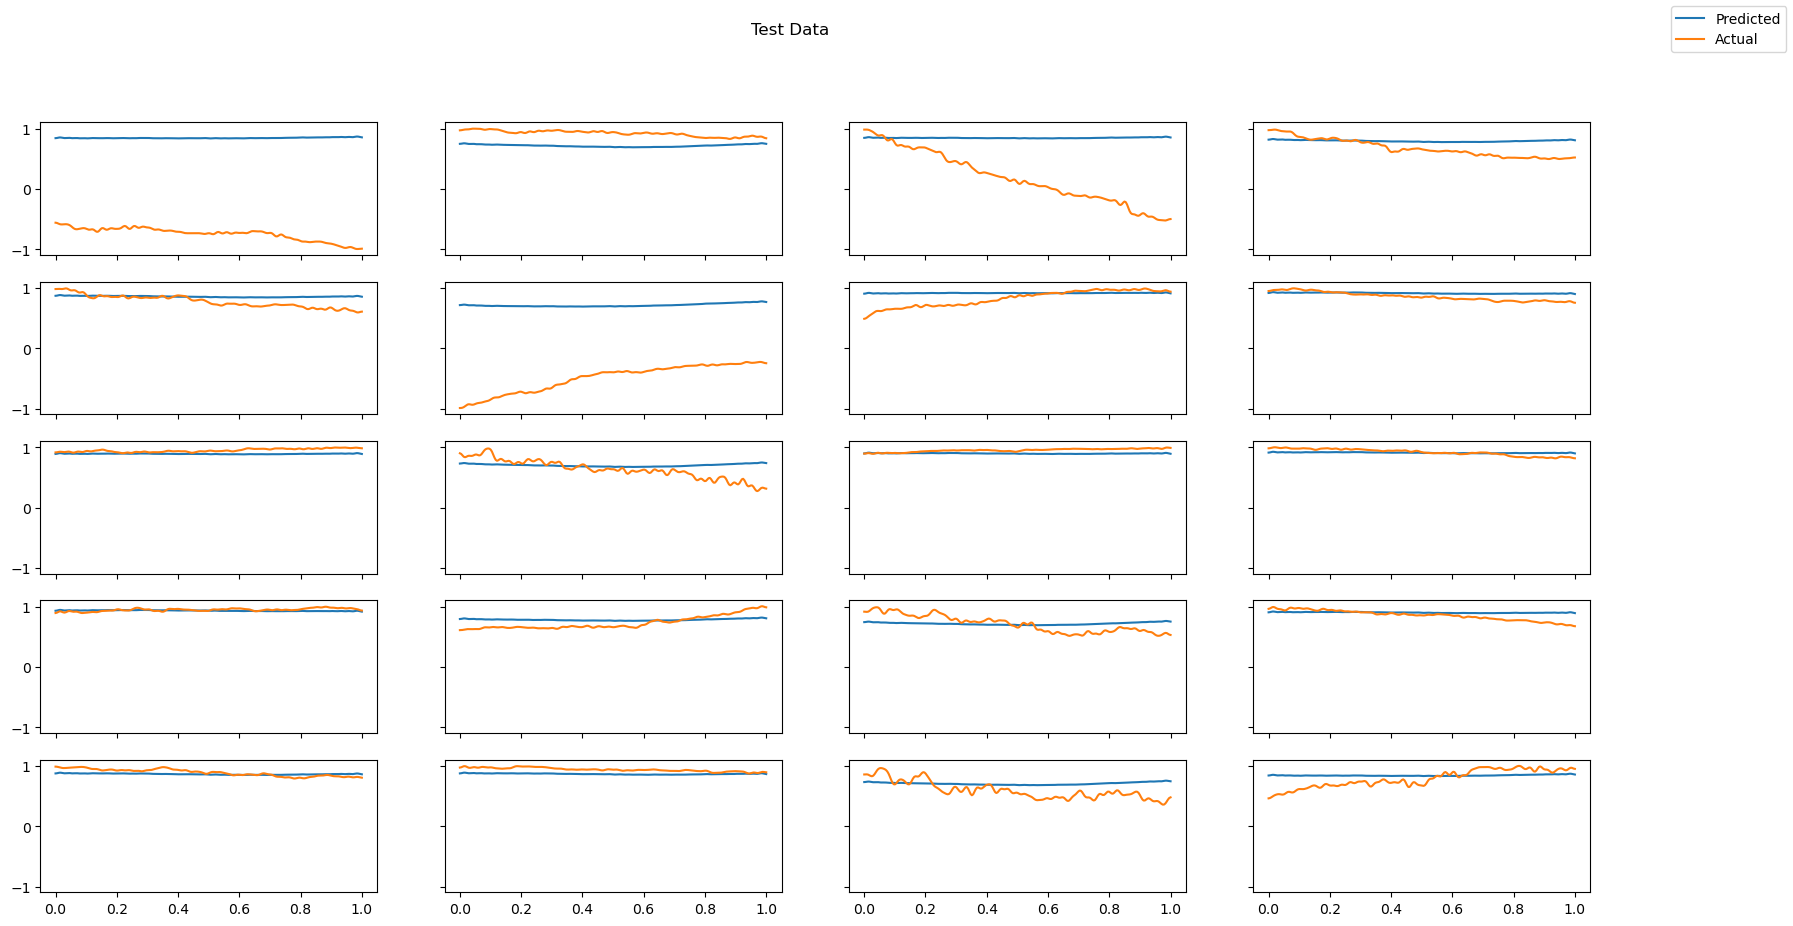

13.524632380515426


In [84]:
plot_predictions(test_inp_B, test_out_B, train_inp_B_s, best_vech_L, best_u, best_D, 20, 'Test Data', best_Gamma, k_mat)

In [85]:
vec_L = vech_to_vec(best_vech_L)
L = vec_L.reshape((n,n))
print(L)

[[ 1.20651052e+00 -4.87790470e-08 -3.33776450e-08 -4.87790383e-08
  -4.87790368e-08 -3.50905452e-08 -1.20651011e+00 -3.68301265e-08
  -3.33776437e-08 -4.87790331e-08 -3.50905422e-08 -3.68301295e-08]
 [-4.87790470e-08  4.57839986e-07 -4.00103506e-08 -3.65803641e-08
  -3.65803644e-08 -4.29456065e-08 -4.87790463e-08 -4.23144426e-08
  -4.00103508e-08 -3.65803655e-08 -4.29456075e-08 -4.23144407e-08]
 [-3.33776450e-08 -4.00103506e-08  6.13618974e-01 -4.00103505e-08
  -4.00103504e-08 -2.99817612e-08 -3.33776438e-08 -3.07863209e-08
  -6.13618625e-01 -4.00103512e-08 -2.99817615e-08 -3.07863199e-08]
 [-4.87790383e-08 -3.65803641e-08 -4.00103505e-08  4.57839960e-07
  -3.65803638e-08 -4.29456059e-08 -4.87790365e-08 -4.23144406e-08
  -4.00103503e-08 -3.65803643e-08 -4.29456061e-08 -4.23144397e-08]
 [-4.87790368e-08 -3.65803644e-08 -4.00103504e-08 -3.65803638e-08
   4.57839956e-07 -4.29456061e-08 -4.87790356e-08 -4.23144399e-08
  -4.00103502e-08 -3.65803639e-08 -4.29456058e-08 -4.23144391e-08]
 [-3.

In [86]:
def display_graph_with_thresh(vech_L, c_num):
    vec_L = vech_to_vec(vech_L)
    L = vec_L.reshape((n,n))
    W = np.diag(np.diag(L)) - L
    G = nx.Graph()
    for i in range(len(W)):
        G.add_node(i+1)
    for i in range(n):
        for j in range(i+1,n):
            if W[i][j] > 0:
                G.add_edge(i+1, j+1, weight=np.log10(W[i][j]))
    plt.figure()
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos, font_color = 'white', node_shape = 'o', with_labels = True, node_color='b', edgelist=edges, edge_color=weights, width=3.0, edge_cmap=plt.cm.Blues)
    sorted_weights = sorted(weights)
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = plt.cm.Blues
    bounds = np.arange(-c_num,1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    fig.colorbar(
        matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=ax,
        boundaries=bounds,
        ticks=bounds,
        spacing='proportional',
        orientation='horizontal',
        label= 'Log scale',
    )

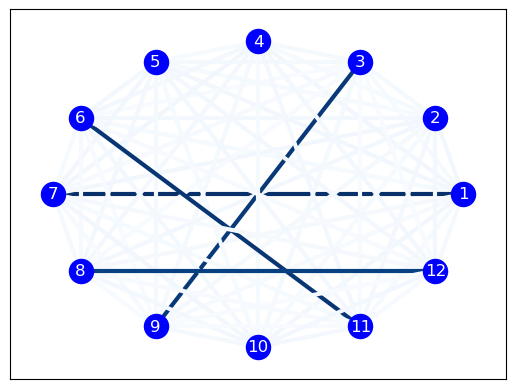

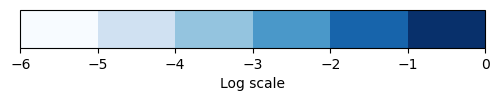

In [87]:
display_graph_with_thresh(best_vech_L, 6)

In [88]:
print(best_D)

[1.00000116 0.99999902 0.99999902 0.99999904 0.99999909 0.99999907
 1.00000137 0.99999923 0.99999903 0.99999915 0.99999911 0.99999913]
